In [183]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
import warnings
warnings.filterwarnings(action = 'ignore')

In [268]:
# # Esatblishing connection with db
conn = sqlite3.connect("database.sqlite")
cur = conn.cursor()

# # Checking the values in 'Player Attribute' table
# cur.execute("""SELECT * FROM Player_Attributes LIMIT 3""")
# for row in cur:
#     print(row)

# # Checking the names of all tables in the db    
cur.execute("""SELECT name FROM sqlite_schema WHERE type='table' ORDER BY name""")
for row in cur:
    print(row)

# # Saving all column names on 'Player Attribut' table 
# table_col_names = []
# cur.execute("""PRAGMA table_info(Player_Attributes)""")
# for row in cur:
#     table_col_names.append(row[1])

# # Closing connection
# cur.close()
# conn.close()

('Country',)
('League',)
('Match',)
('Player',)
('Player_Attributes',)
('Team',)
('Team_Attributes',)
('sqlite_sequence',)


In [16]:
# Checking the values in 'Player Attribute' table
# cur.execute("""SELECT * FROM Match LIMIT 3""")
# for row in cur:
#     print(row)

In [7]:
df_countries_raw = pd.read_sql_query("SELECT * FROM Country", conn)
df_countries = df_countries_raw.copy()
df_countries.head()

,id,name
0,1,Belgium
1,1729,England
2,4769,France
3,7809,Germany
4,10257,Italy


In [10]:
df_league_raw = pd.read_sql_query("SELECT * FROM League", conn)
df_league = df_league_raw.copy()
df_league.head()

,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A


In [17]:
df_match_raw = pd.read_sql_query("SELECT * FROM Match", conn)
df_match = df_match_raw.copy()
df_match.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


In [20]:
df_player_raw = pd.read_sql_query("SELECT * FROM Player", conn)
df_player = df_player_raw.copy()
df_player.head()

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
1,2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146
2,3,162549,Aaron Doran,186170,1991-05-13 00:00:00,170.18,163
3,4,30572,Aaron Galindo,140161,1982-05-08 00:00:00,182.88,198
4,5,23780,Aaron Hughes,17725,1979-11-08 00:00:00,182.88,154


In [22]:
df_team_raw = pd.read_sql_query("SELECT * FROM Team", conn)
df_team = df_team_raw.copy()
df_team.head()

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC
2,3,10000,15005.0,SV Zulte-Waregem,ZUL
3,4,9994,2007.0,Sporting Lokeren,LOK
4,5,9984,1750.0,KSV Cercle Brugge,CEB


In [24]:
df_teamattr_raw = pd.read_sql_query("SELECT * FROM Team_Attributes", conn)
df_teamattr = df_teamattr_raw.copy()
df_teamattr.head()

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,1,434,9930,2010-02-22 00:00:00,60,Balanced,NaN,Little,50,Mixed,...,55,Normal,Organised,50,Medium,55,Press,45,Normal,Cover
1,2,434,9930,2014-09-19 00:00:00,52,Balanced,48.0,Normal,56,Mixed,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
2,3,434,9930,2015-09-10 00:00:00,47,Balanced,41.0,Normal,54,Mixed,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
3,4,77,8485,2010-02-22 00:00:00,70,Fast,NaN,Little,70,Long,...,70,Lots,Organised,60,Medium,70,Double,70,Wide,Cover
4,5,77,8485,2011-02-22 00:00:00,47,Balanced,NaN,Little,52,Mixed,...,52,Normal,Organised,47,Medium,47,Press,52,Normal,Cover


#### Tables obtained:
- Countries: ['id', 'name']
- League: ['id', 'country_id', 'name']
- Match: ['id', 'country_id', 'league_id', 'season', 'stage', 'date', 'match_api_id', 'home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal', 'goal', 'shoton', 'shotoff', 'foulcommit', 'card', 'cross', 'corner', 'possession']
- Player: ['id', 'player_api_id', 'player_name', 'player_fifa_api_id', 'birthday', 'height', 'weight']
- Team: ['id', 'team_api_id', 'team_fifa_api_id', 'team_long_name', 'team_short_name']
- Team Attributes: ['id', 'team_fifa_api_id', 'team_api_id', 'date', 'buildUpPlaySpeed', 'buildUpPlaySpeedClass', 'buildUpPlayDribbling', 'buildUpPlayDribblingClass']
- Player Attributes ('df')

In [126]:
# Name of the leagues of each countries
league_names = pd.merge(left = df_countries, right = df_league, left_on = 'id', 
                        right_on = 'country_id').rename(columns = {'name_x': 'country', 'name_y': 'league_name'})[['country', 'league_name']]
league_names

,country,league_name
0,Belgium,Belgium Jupiler League
1,England,England Premier League
2,France,France Ligue 1
3,Germany,Germany 1. Bundesliga
4,Italy,Italy Serie A
5,Netherlands,Netherlands Eredivisie
6,Poland,Poland Ekstraklasa
7,Portugal,Portugal Liga ZON Sagres
8,Scotland,Scotland Premier League
9,Spain,Spain LIGA BBVA


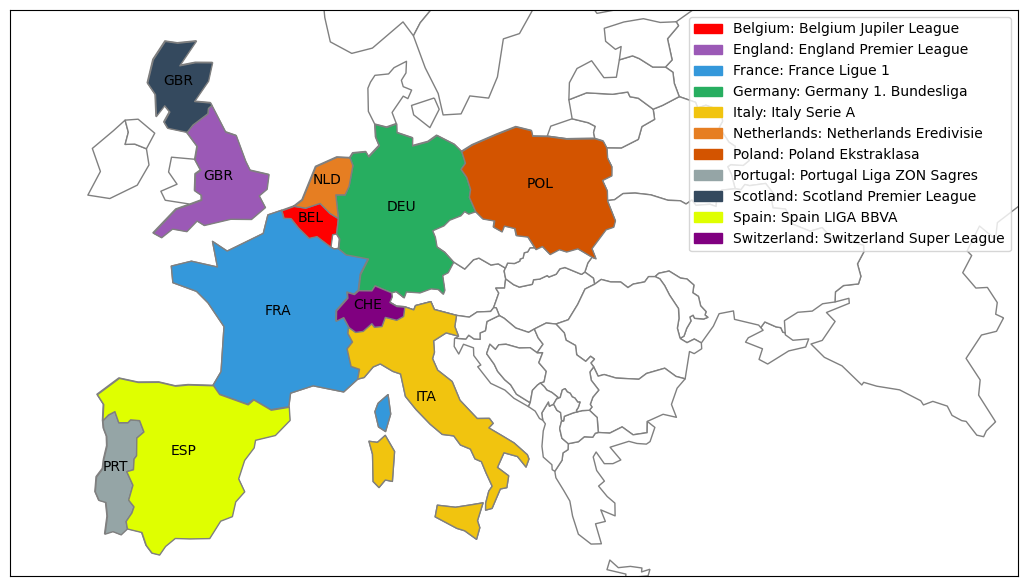

In [325]:
import matplotlib.patches as mpatches
import geopandas as gpd

world = gpd.read_file(r"countries1/ne_110m_admin_0_map_units.shp")

colors = ["#FF0000", "#9B59B6", "#3498DB", "#27AE60", "#F1C40F", "#E67E22", "#D35400", "#95A5A6", "#34495E", "#DFFF00", "#800080"]

ax1 = world[world.CONTINENT == 'Europe'].plot(figsize=(13,9), edgecolor=u'gray', color = "white")

for idx, name in enumerate(league_names.country):
    world[world.NAME == name].plot(edgecolor = u'gray', color = colors[idx], ax=ax1)

for country in league_names.country:
    plt.text(x = world.loc[world.NAME == country].centroid.x.values[0] - 1, 
             y = world.loc[world.NAME == country].centroid.y.values[0], 
             s = world.loc[world.NAME == country]['ADM0_A3'].values[0])

legends = []
for color, name in zip(colors, league_names.values):
    legends.append(mpatches.Patch(color = color, label = name[0] + ": " + name[1]))
    
# plt.ylabel('Latitude')
# plt.xlabel('Longitude')

plt.xlim(-15, 50)
plt.ylim(35, 60)
plt.xticks([])
plt.yticks([])
plt.legend(handles=legends) #, bbox_to_anchor = [1.55,1.01]
plt.show()

In [273]:
# Might want to scrape data 
# Check what team plays for what league and country

In [313]:
temp = pd.merge(left = df_match[['country_id', 'league_id', 'home_team_api_id', 'away_team_api_id']],
         right = df_team[['team_api_id', 'team_long_name']],
         left_on = 'home_team_api_id', right_on = 'team_api_id')
team_league = pd.merge(left = temp, right = df_league, left_on = 'country_id', right_on = 'id')
team_league_country = pd.merge(left = team_league, right = df_countries, left_on = 'country_id_x', right_on = 'id')[['team_long_name', 'name_x', 'name_y']]
team_league_country = team_league_country.rename(columns = {'team_long_name': 'team','name_x': 'league', 'name_y': 'country'})
team_league_country.head()

,team,league,country
0,KRC Genk,Belgium Jupiler League,Belgium
1,KRC Genk,Belgium Jupiler League,Belgium
2,KRC Genk,Belgium Jupiler League,Belgium
3,KRC Genk,Belgium Jupiler League,Belgium
4,KRC Genk,Belgium Jupiler League,Belgium


In [322]:
team_league_country.groupby('league').nunique()['team']

league
Belgium Jupiler League      24
England Premier League      34
France Ligue 1              35
Germany 1. Bundesliga       30
Italy Serie A               32
Netherlands Eredivisie      25
Poland Ekstraklasa          22
Portugal Liga ZON Sagres    29
Scotland Premier League     17
Spain LIGA BBVA             33
Switzerland Super League    15
Name: team, dtype: int64

In [3]:
# print(len(table_col_names))
# table_col_names

In [28]:
conn = sqlite3.connect('database.sqlite')
df_raw = pd.read_sql_query("SELECT * FROM Player_Attributes", conn)
conn.close()

In [29]:
df = df_raw.copy()

In [30]:
df.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [37]:
df.shape

(183978, 42)

In [8]:
# Backward Elimination

In [9]:
# df.info()

In [41]:
# df.drop(["id", "player_fifa_api_id", "player_api_id", "date"], axis = 1, inplace = True)

In [40]:
# df.dropna(inplace = True)
# print(df.shape)

In [42]:
cat_cols = df.select_dtypes(include = 'object')

In [43]:
cat_cols.nunique()

preferred_foot          2
attacking_work_rate     8
defensive_work_rate    18
dtype: int64

In [44]:
for i in cat_cols.columns:
    print(cat_cols[i].unique())

['right' 'left']
['medium' 'high' 'low' 'None' 'le' 'norm' 'stoc' 'y']
['medium' 'high' 'low' '5' 'ean' 'o' '1' 'ormal' '7' '2' '8' '4' 'tocky'
 '0' '3' '6' '9' 'es']


In [45]:
cat_cols['attacking_work_rate'].value_counts(normalize = True)

medium    0.693470
high      0.237439
low       0.047512
None      0.018392
norm      0.001758
y         0.000521
stoc      0.000477
le        0.000432
Name: attacking_work_rate, dtype: float64

In [46]:
# cat_cols['defensive_work_rate'].value_counts(normalize = True)

In [47]:
cat_cols.loc[~cat_cols['attacking_work_rate'].isin(['medium', 'high', 'low']), 'attacking_work_rate'] = 'other'

In [48]:
cat_cols.loc[~cat_cols['defensive_work_rate'].isin(['medium', 'high', 'low']), 'defensive_work_rate'] = 'other'

In [49]:
cat_cols = pd.get_dummies(cat_cols, columns = ['preferred_foot'])

In [50]:
ordinal_encode = {'other': 0, 'low': 1, 'medium': 2, 'high': 3}
cat_cols['attacking_work_rate'] = cat_cols['attacking_work_rate'].map(ordinal_encode)
cat_cols['defensive_work_rate'] = cat_cols['defensive_work_rate'].map(ordinal_encode)

In [51]:
# cat_cols

In [52]:
df.drop(["preferred_foot", "attacking_work_rate", "defensive_work_rate"], axis = 1, inplace = True)

In [53]:
df = pd.concat([df, cat_cols], axis = 1)

In [119]:
# df.info()

In [34]:
# Build model using sk
# Check important features using stats model?
# Multicolinearity?
# Check model assumptions from textbook
# Recursive feature elimination
# Cross validate
# L1 and L2 regression

In [54]:
df_50 = df.sample(n = 50000)

In [56]:
# df_50.info()

In [57]:
y = df_50['overall_rating']
X = df_50.drop('overall_rating', axis = 1)

In [58]:
col_name = X.columns

In [59]:
y_unscaled = y.copy()

In [60]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scale = scaler.fit_transform(X)
y_scale = scaler.fit_transform(y.values.reshape((50000, 1)))

In [61]:
# Baseline Model
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(X, y, test_size = 0.3)
lin_model1 = LinearRegression()
lin_model1.fit(X_train_base, y_train_base)
y_pred1 = lin_model1.predict(X_test_base)
rmse_base = math.sqrt(mean_squared_error(y_true = y_test_base, y_pred = y_pred1))
print(rmse_base)

2.809648141185665


In [62]:
import statsmodels.regression.linear_model as sm

In [63]:
stat_ols = sm.OLS(endog = y_scale, exog = X_scale).fit()
# stat_ols.summary()

In [64]:
# stat_ols.pvalues[stat_ols.pvalues>0.05]
np.argwhere(stat_ols.pvalues<=0.05).flatten()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34],
      dtype=int64)

In [65]:
stat_ols.pvalues.shape

(38,)

In [66]:
np.argwhere(stat_ols.pvalues != np.max(stat_ols.pvalues)).flatten()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 36, 37], dtype=int64)

In [73]:
def backward_elimination(X, y):
    significant_cols = np.array(range(38))
    p_val = [1]
    while len(p_val) > 0:
        stat_ols = sm.OLS(endog = y, exog = X[:, significant_cols]).fit()
        p_val = np.argwhere(stat_ols.pvalues>0.05).flatten()
        significant_cols = np.argwhere(stat_ols.pvalues != np.max(stat_ols.pvalues)).flatten()
    return significant_cols

In [74]:
features = backward_elimination(X_scale, y_scale)

In [75]:
len(features)

33

In [76]:
features = col_name[features]

In [77]:
X_ols = X.loc[:, features]
X_ols.head()

,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
88301,60.0,43.0,42.0,57.0,47.0,28.0,39.0,53.0,19.0,56.0,...,57.0,63.0,60.0,56.0,82.0,9.0,21.0,56.0,21.0,21.0
72714,86.0,72.0,64.0,56.0,88.0,75.0,86.0,81.0,75.0,82.0,...,86.0,66.0,50.0,74.0,65.0,11.0,14.0,5.0,5.0,13.0
85825,70.0,62.0,60.0,30.0,65.0,50.0,73.0,59.0,66.0,57.0,...,62.0,48.0,43.0,49.0,35.0,11.0,6.0,11.0,11.0,14.0
154967,72.0,21.0,22.0,13.0,16.0,13.0,18.0,12.0,17.0,15.0,...,31.0,14.0,16.0,12.0,21.0,68.0,69.0,66.0,67.0,68.0
95102,67.0,12.0,13.0,14.0,17.0,14.0,16.0,13.0,24.0,30.0,...,26.0,14.0,14.0,14.0,17.0,64.0,66.0,65.0,72.0,66.0


In [78]:
# plt.figure(figsize = (15, 15))
# sns.heatmap(X.corr())

<Axes: >

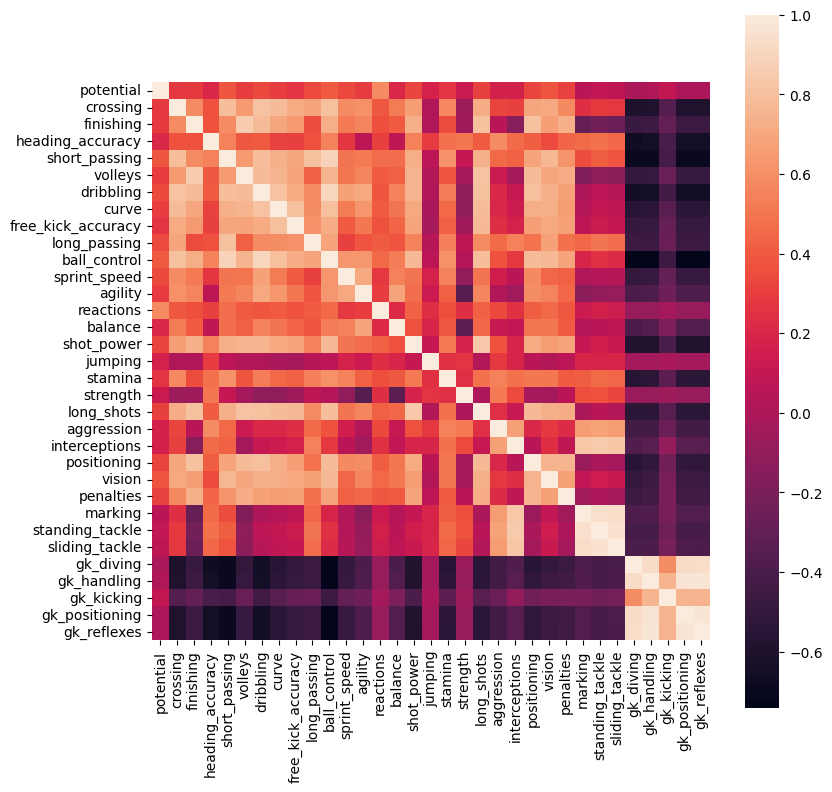

In [80]:
plt.figure(figsize = (9,9))
sns.heatmap(X_ols.corr(), square = True)

In [81]:
X_train_ols, X_test_ols, y_train_ols, y_test_ols = train_test_split(X_ols, y, test_size = 0.3)
lin_model2 = LinearRegression()
lin_model2.fit(X_train_ols, y_train_ols)
y_pred2 = lin_model2.predict(X_test_ols)
rmse_ols = math.sqrt(mean_squared_error(y_true = y_test_ols, y_pred = y_pred2))
print(rmse_ols)

2.8146985991773312


In [82]:
# "overall_rating"
# out = df_50.reset_index(drop = True)
# out.to_csv('soccer_50.csv')

In [83]:
r_features = '''potential + crossing + finishing + heading_accuracy + short_passing + dribbling + curve + free_kick_accuracy + 
    long_passing + ball_control + acceleration + sprint_speed + 
    agility + reactions + balance + shot_power + jumping + stamina + 
    strength + long_shots + aggression + interceptions + positioning + 
    penalties + marking + sliding_tackle + gk_diving + gk_handling + 
    gk_kicking + gk_positioning + gk_reflexes + attacking_work_rate
    '''

#### Features obtained from backward elimination process done in R, using AIC metric
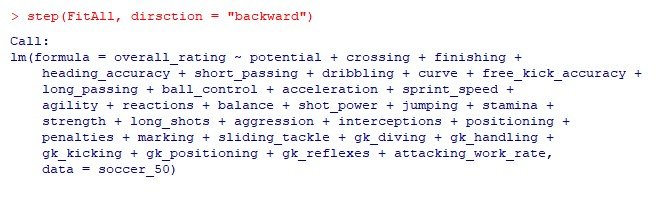

In [86]:
# r_features = [i for i in r_features.split() if i != "+"]
print(r_features)
len(r_features)

['potential', 'crossing', 'finishing', 'heading_accuracy', 'short_passing', 'dribbling', 'curve', 'free_kick_accuracy', 'long_passing', 'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots', 'aggression', 'interceptions', 'positioning', 'penalties', 'marking', 'sliding_tackle', 'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes', 'attacking_work_rate']


32

In [87]:
X_r = X.loc[:, r_features]

In [88]:
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_r, y, test_size = 0.3)
lin_model3 = LinearRegression()
lin_model3.fit(X_train_r, y_train_r)
y_pred3 = lin_model3.predict(X_test_r)
rmse_r = math.sqrt(mean_squared_error(y_true = y_test_r, y_pred = y_pred3))
print(rmse_r)

2.804903331653909


In [89]:
# RMSE of training data
y_pred4 = lin_model3.predict(X_train_r)
rmse_r_train = math.sqrt(mean_squared_error(y_true = y_train_r, y_pred = y_pred4))
print(rmse_r_train)

2.811074834688958


In [90]:
# Checking residuals
e1_train = y_pred4 - y_train_r
e1_test = y_pred3 - y_test_r

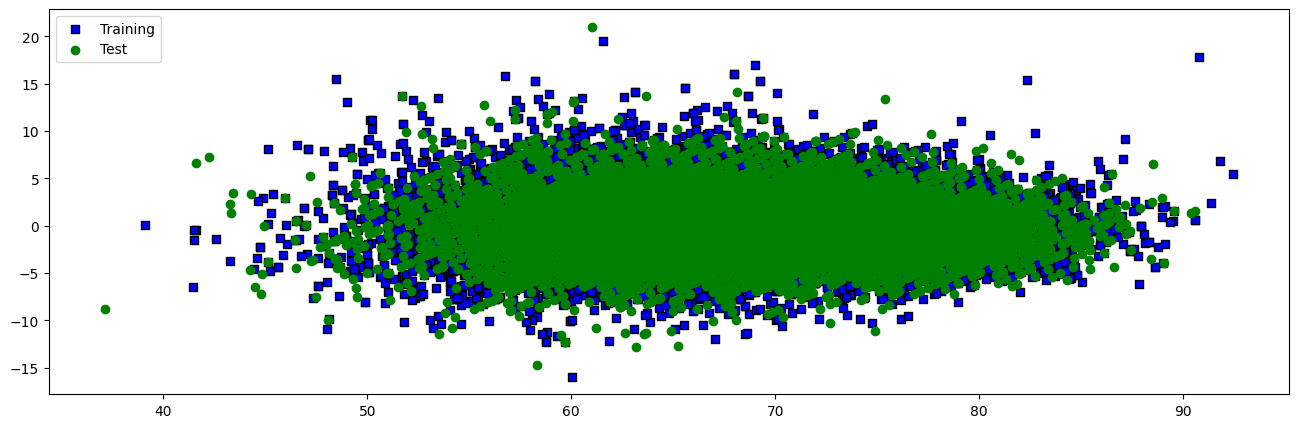

In [91]:
plt.figure(figsize = (16, 5))
plt.scatter(x = y_pred4, y = e1_train, c = 'blue', marker = 's', label = 'Training', edgecolors = 'black')
plt.scatter(x = y_pred3, y = e1_test, c = 'green', label = 'Test')
plt.legend()

In [92]:
# L1 and L2 regularization
from sklearn.linear_model import RidgeCV, LassoCV

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

lin_ridge = RidgeCV(alphas = [2200, 2300, 2400, 2500, 2600], cv = 10)
lin_ridge.fit(X_train, y_train)
print("Best alpha", lin_ridge.alpha_)

y_pred5_train = lin_ridge.predict(X_train)
y_pred5_test = lin_ridge.predict(X_test)

rmse_ridge_train = math.sqrt(mean_squared_error(y_true = y_train, y_pred = y_pred5_train))
print(rmse_ridge_train)
rmse_ridge_test = math.sqrt(mean_squared_error(y_true = y_test, y_pred = y_pred5_test))
print(rmse_ridge_test)

Best alpha 2200
2.802647226253723
2.8235889869615183


<BarContainer object of 38 artists>

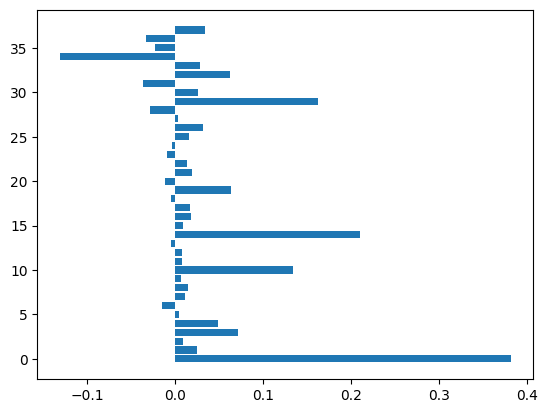

In [93]:
plt.barh(y = pd.Series(lin_ridge.coef_).index, width = lin_ridge.coef_, align = 'center')

In [105]:
lin_lasso = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1], max_iter = 50000, cv = 10)
lin_lasso.fit(X_train, y_train)
print("Best alpha", lin_lasso.alpha_)

y_pred6_train = lin_lasso.predict(X_train)
y_pred6_test = lin_lasso.predict(X_test)

rmse_lasso_train = math.sqrt(mean_squared_error(y_true = y_train, y_pred = y_pred6_train))
print(rmse_lasso_train)
rmse_lasso_test = math.sqrt(mean_squared_error(y_true = y_test, y_pred = y_pred6_test))
print(rmse_lasso_test)

Best alpha 0.003
2.8026157082948604
2.8236256702503697


<BarContainer object of 38 artists>

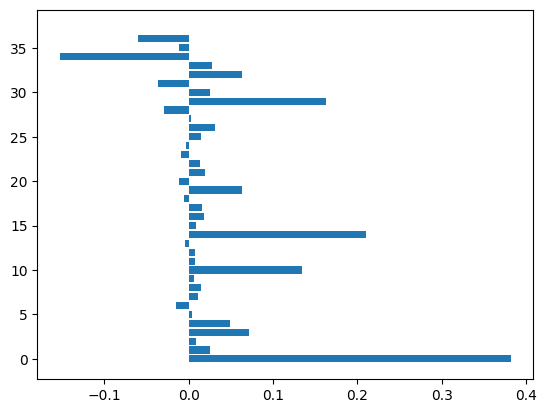

In [95]:
plt.barh(y = pd.Series(lin_lasso.coef_).index, width = lin_lasso.coef_, align = 'center')

In [156]:
# e1_train = y_train - y_pred5_train
# e1_test = y_test - y_pred5_test
# plt.figure(figsize = (16, 5))
# plt.scatter(x = y_pred5_train, y = e1_train, c = 'blue', marker = 's', label = 'Training', edgecolors = 'black')
# plt.scatter(x = y_pred5_test, y = e1_test, c = 'green', label = 'Test')
# plt.legend()

In [112]:
# Trying polynomial fetures
pipe = Pipeline(steps = [('poly', PolynomialFeatures(degree = 2)),
                         ('lassoCV', Lasso(alpha = 0.1))])

In [113]:
pipe.fit(X_train, y_train)

C:\Users\CSC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.787e+04, tolerance: 1.741e+02
  model = cd_fast.enet_coordinate_descent(


Pipeline(steps=[('poly', PolynomialFeatures()), ('lassoCV', Lasso(alpha=0.1))])

In [114]:
y_pred7_poly = pipe.predict(X_test)
rmse_poly = math.sqrt(mean_squared_error(y_true = y_test, y_pred = y_pred7_poly))
print(rmse_poly)

1.4772539780846727


In [122]:
# Did not converge, hence scaling the values and adding more iterations to Lasso
pipe2 = Pipeline(steps = [('scale', StandardScaler()),
                         ('poly', PolynomialFeatures(degree = 2)),
                         ('lassoCV', Lasso(alpha = 0.1, max_iter = 50000))])

In [123]:
# pipe2.named_steps.scale.fit_transform(X, y).shape

In [124]:
pipe2.fit(X_train, y_train)

Pipeline(steps=[('scale', StandardScaler()), ('poly', PolynomialFeatures()),
                ('lassoCV', Lasso(alpha=0.1, max_iter=50000))])

In [130]:
y_pred8_poly = pipe2.predict(X_test)
rmse_poly2 = math.sqrt(mean_squared_error(y_true = y_test, y_pred = y_pred8_poly))
print(rmse_poly2)

1.7442853923753494


In [36]:
# Manually selecting features (34)
features = ['potential', 'crossing', 'finishing', 'heading_accuracy',
           'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
           'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
           'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
           'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
           'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
           'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',
           'gk_reflexes']
target = ['overall_rating']

In [38]:
# df_50.info()

In [40]:
df_50 = df_50.dropna()
df_50.shape

(49012, 42)

In [41]:
X = df_50[features]
y = df_50[target]

In [45]:
X.head()

,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
92296,69.0,64.0,62.0,43.0,62.0,49.0,68.0,69.0,68.0,60.0,...,63.0,61.0,16.0,27.0,29.0,13.0,8.0,6.0,7.0,6.0
50343,83.0,50.0,44.0,57.0,73.0,50.0,72.0,49.0,57.0,66.0,...,67.0,59.0,54.0,59.0,47.0,13.0,7.0,7.0,12.0,10.0
107417,64.0,58.0,45.0,52.0,55.0,52.0,63.0,47.0,56.0,54.0,...,54.0,41.0,36.0,42.0,28.0,10.0,6.0,11.0,12.0,9.0
118031,72.0,47.0,75.0,77.0,66.0,70.0,62.0,49.0,39.0,41.0,...,68.0,68.0,22.0,29.0,17.0,3.0,3.0,3.0,3.0,3.0
89882,72.0,31.0,33.0,68.0,52.0,32.0,41.0,29.0,30.0,47.0,...,35.0,39.0,68.0,69.0,68.0,15.0,10.0,10.0,12.0,15.0


In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [49]:
lin_model1 = LinearRegression()
lin_model1.fit(X_train, y_train)

LinearRegression()

In [50]:
y_pred1 = lin_model1.predict(X_test)
y_pred1

array([[79.01520896],
       [78.22603517],
       [74.33510149],
       ...,
       [69.87301914],
       [68.27069969],
       [66.37610715]])

In [52]:
y_pred1.mean()

68.597019183854

In [53]:
df['overall_rating'].mean()

68.6000152886831

In [80]:
# Root Mean Squared Error
rmse_lin = math.sqrt(mean_squared_error(y_true = y_test, y_pred = y_pred1))
print(rmse_lin)

2.7886874646658746


In [77]:
rf1 = RandomForestRegressor()
rf1.fit(X_train, y_train.values.flatten())

RandomForestRegressor()

In [78]:
y_pred2 = rf1.predict(X_test)
y_pred2

array([78.6       , 77.81      , 74.78      , ..., 72.83416667,
       69.305     , 63.906     ])

In [79]:
y_pred2.mean()

68.60118758957422

In [81]:
rmse_rf = math.sqrt(mean_squared_error(y_true = y_test, y_pred = y_pred2))
print(rmse_rf)

1.3415178752503538
